In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from scipy.optimize import minimize
import itertools

# Q1

In [33]:
def movingAverageCrossover(df, fastWindow=45, slowWindow=200):
    df = df.copy()
    df["fast_MA"] = df.iloc[:, 0].rolling(window=fastWindow).mean()
    df["slow_MA"] = df.iloc[:, 0].rolling(window=slowWindow).mean()

    df["signal_flat"] = np.where(df["fast_MA"] > df["slow_MA"], 1, 0)
    df["signal_short"] = np.where(df["fast_MA"] > df["slow_MA"], 1, -1)

    df["BMK-MA"] = df.iloc[:, 0].pct_change()
    df["MAFlat"] = df["BMK-MA"] * df["signal_flat"].shift(1)
    df["MAShort"] = df["BMK-MA"] * df["signal_short"].shift(1)

    return df[["BMK-MA", "MAFlat", "MAShort"]].dropna()


In [34]:
def bollingerBands(df, bbWindow=20, stdevBand=2):
    df = df.copy()
    rolling_mean = df.iloc[:, 0].rolling(window=bbWindow).mean()
    rolling_std = df.iloc[:, 0].rolling(window=bbWindow).std()

    upper_band = rolling_mean + (stdevBand * rolling_std)
    lower_band = rolling_mean - (stdevBand * rolling_std)

    df["signal"] = np.where(df.iloc[:, 0] < lower_band, 1, np.where(df.iloc[:, 0] > upper_band, -1, 0))
    df["BMK-BB"] = df.iloc[:, 0].pct_change()
    df["BB"] = df["BMK-BB"] * df["signal"].shift(1)

    return df[["BMK-BB", "BB"]].dropna()

In [35]:
def runMovingAverageAndBB(df, fastWindow=45, slowWindow=200, bbWindow=20, stdevBand=2):
    ma_result = movingAverageCrossover(df, fastWindow, slowWindow)
    bb_result = bollingerBands(df, bbWindow, stdevBand)
    result = ma_result.join(bb_result, how="inner")
    return result


# Q2

In [36]:
def read_price_data(filename, index_col=0, parse_dates=True):
    print("Reading data from:", filename)

    # Read the CSV file
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)

    # Print DataFrame info
    print("\n--- DataFrame Info ---")
    print(df.info())

    # Check for null values
    print("\n--- Checking for Missing Values ---")
    print(df.isnull().sum())

    # Print summary statistics
    print("\n--- Summary Statistics ---")
    print(df.describe())

    # Display DataFrame
    print("\n--- Data Preview ---")
    print(df.head())

    return df

In [37]:
prices_df = read_price_data('PricesForProject.csv')

Reading data from: PricesForProject.csv

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4780 entries, 1999-12-31 to 2018-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4780 non-null   float64
 1   CAD     4780 non-null   float64
 2   EXC     4780 non-null   float64
 3   FBNDX   4780 non-null   float64
 4   GBP     4780 non-null   float64
 5   GE      4780 non-null   float64
 6   INTC    4780 non-null   float64
 7   PFE     4780 non-null   float64
 8   SPGSCI  4780 non-null   float64
 9   SPY     4780 non-null   float64
 10  VBTIX   4780 non-null   float64
 11  XPT     4780 non-null   float64
dtypes: float64(12)
memory usage: 485.5 KB
None

--- Checking for Missing Values ---
AAPL      0
CAD       0
EXC       0
FBNDX     0
GBP       0
GE        0
INTC      0
PFE       0
SPGSCI    0
SPY       0
VBTIX     0
XPT       0
dtype: int64

--- Summary Statistics ---
              AAPL     

# Q3

In [38]:
# Select Instruments
selected_instruments = ["AAPL", "EXC", "GE", "INTC", "PFE", "FBNDX", "SPGSCI", "GBP"]

In [39]:
# fast_window_range = range(5, 110, 1)       # Fast moving average: 5 to 50 in steps of 5
# slow_window_range = range(50, 500, 5)   # Slow moving average: 100 to 300 in steps of 20
# bb_window_range = range(20, 50, 5)        # Bollinger Bands window: 20 to 50 in steps of 5
# stdev_band_range = np.arange(1.5, 3.5, 0.5)  # Standard deviation bands: 1.5 to 3.5 in steps of 0.5


In [40]:
# sensitivity_results = []
#
# for fast, slow, bb_window, stdev in itertools.product(fast_window_range, slow_window_range, bb_window_range, stdev_band_range):
#
#     # Ensure fastWindow < slowWindow
#     if fast >= slow:
#         continue
#
#     fast = int(fast)
#     slow = int(slow)
#     bb_window = int(bb_window)
#
#     portfolio_returns = pd.DataFrame()
#     for instrument in selected_instruments:
#         df = prices_df[[instrument]]
#         strategy_result = runMovingAverageAndBB(df, fast, slow, bb_window, stdev)
#
#         # Rename columns
#         strategy_result.columns = [f"{instrument}-{col}" for col in strategy_result.columns]
#
#         # Store all strategy results
#         portfolio_returns = pd.concat([portfolio_returns, strategy_result], axis=1)
#
#     # Compute Sharpe Ratio
#     sharpe = portfolio_returns.apply(lambda x: x.mean() / x.std()).mean()  # Average Sharpe across all instruments
#     sensitivity_results.append((fast, slow, bb_window, stdev, sharpe))
#
# # Convert results to DataFrame
# sensitivity_df = pd.DataFrame(sensitivity_results, columns=["FastWindow", "SlowWindow", "BBWindow", "StdevBand", "SharpeRatio"])
#
# # Find the best parameter set
# best_params = sensitivity_df.sort_values(by="SharpeRatio", ascending=False).iloc[0]
# fast_best, slow_best, bb_best, stdev_best = best_params[:4]
#
# fast_best = int(best_params["FastWindow"])
# slow_best = int(best_params["SlowWindow"])
# bb_best = int(best_params["BBWindow"])
# stdev_best = best_params["StdevBand"]
#
# print(f"Best Parameters - Fast MA: {fast_best}, Slow MA: {slow_best}, BB Window: {bb_best}, Stdev Band: {stdev_best}")
#
# # Run Best Strategy on Selected Instruments
# portfolio_returns = pd.DataFrame()
# strategy_selection = {}
#
# for instrument in selected_instruments:
#     df = prices_df[[instrument]]
#     strategy_result = runMovingAverageAndBB(df, fast_best, slow_best, bb_best, stdev_best)
#
#     # Rename columns
#     strategy_result.columns = [f"{instrument}-{col}" for col in strategy_result.columns]
#
#     # Store strategy results
#     portfolio_returns = pd.concat([portfolio_returns, strategy_result], axis=1)
#
#     # Select the best strategy for this instrument
#     instrument_sharpes = strategy_result.apply(lambda x: x.mean() / x.std()).dropna()
#     best_strategy = instrument_sharpes.idxmax()
#     strategy_selection[instrument] = best_strategy
#
#
# print("Best Strategy Selection for Each Instrument:")
# print(strategy_selection)
#
# Best Parameters - Fast MA: 87, Slow MA: 130, BB Window: 45, Stdev Band: 2.0
# Best Strategy Selection for Each Instrument:
#     {'AAPL': 'AAPL-MAFlat', 'EXC': 'S', 'GE': 'GE-MAShort', 'INTC': 'INTC-BB', 'PFE': 'PFE-BB', 'FBNDX': 'FBNDX-MAShort', 'SPGSCI': 'SPGSCI-MAFlat', 'GBP': 'GBP-MAShort'}

# Q4

Best Parameters - Fast MA: 87, Slow MA: 130, BB Window: 45, Stdev Band: 2.0
Best Strategy Selection for Each Instrument:
   {'AAPL': 'AAPL-MAFlat', 'EXC': 'EXC-BMK-MA', 'GE': 'GE-MAShort', 'INTC': 'INTC-BB', 'PFE': 'PFE-BB', 'FBNDX': 'FBNDX-MAShort', 'SPGSCI': 'SPGSCI-MAFlat', 'GBP': 'GBP-MAShort'}

# Q5

In [41]:
maFast = 87
maSlow = 130
bbWindow = 45
bbStdevBand = 2
myStrategies = ['AAPL-MAFlat', 'EXC-BMK-MA', 'FBNDX-MAShort', 'GBP-MAShort', 'GE-MAShort', 'INTC-BB', 'PFE-BB', 'SPGSCI-MAFlat']

# Q6


 Master DataFrame Shape: (4779, 60)

 First 5 rows of Master DataFrame:
             AAPL-BMK-MA  AAPL-MAFlat  AAPL-MAShort  AAPL-BMK-BB  AAPL-BB  \
Date                                                                       
2000-01-03     0.088754          0.0     -0.088754     0.088754      0.0   
2000-01-04    -0.084310         -0.0      0.084310    -0.084310     -0.0   
2000-01-05     0.014633          0.0     -0.014633     0.014633      0.0   
2000-01-06    -0.086538         -0.0      0.086538    -0.086538     -0.0   
2000-01-07     0.047369          0.0     -0.047369     0.047369      0.0   

            CAD-BMK-MA  CAD-MAFlat  CAD-MAShort  CAD-BMK-BB  CAD-BB  ...  \
Date                                                                 ...   
2000-01-03   -0.000484        -0.0     0.000484   -0.000484    -0.0  ...   
2000-01-04   -0.004130        -0.0     0.004130   -0.004130    -0.0  ...   
2000-01-05    0.001931         0.0    -0.001931    0.001931     0.0  ...   
2000-01-06   

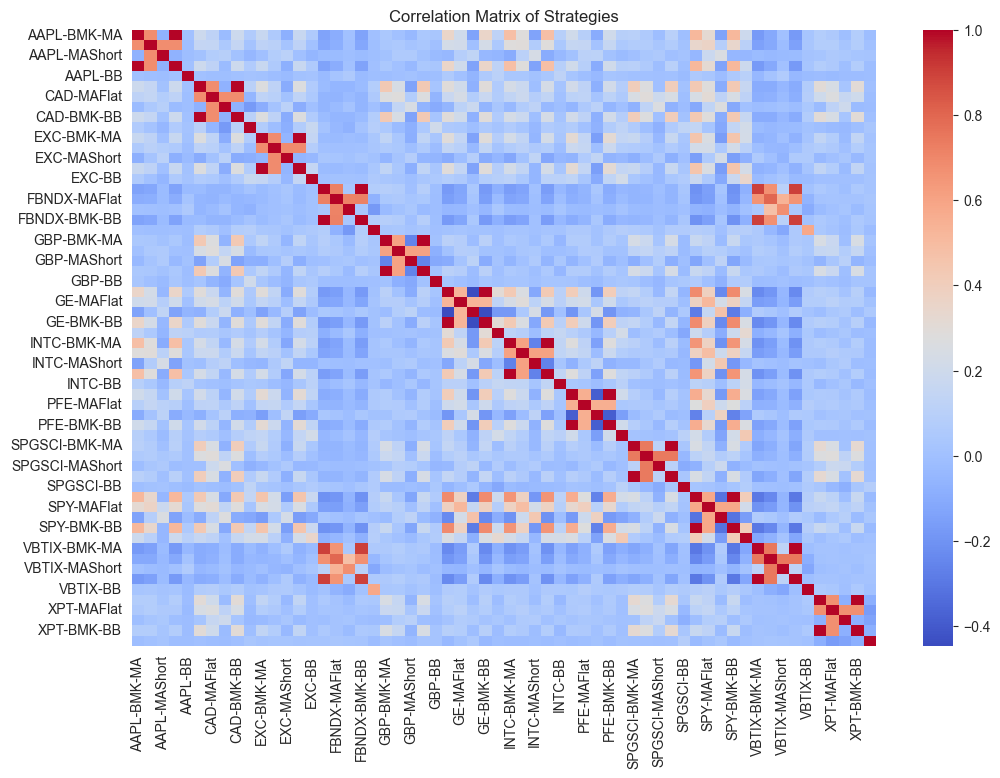

In [42]:
# Define All 12 Instruments (in Alphabetical Order)
all_instruments = sorted(prices_df.columns)  # Sort alphabetically

# Define the Best Parameters
fast_best, slow_best, bb_best, stdev_best = 87, 130, 45, 2.0

# Initialize Master DataFrame
master_df = pd.DataFrame()

# Run Strategies on All 12 Instruments
for instrument in all_instruments:
    df = prices_df[[instrument]]

    # Apply the strategy using the best parameters
    strategy_result = runMovingAverageAndBB(df, fast_best, slow_best, bb_best, stdev_best)

    # Rename columns to include instrument name
    strategy_result.columns = [f"{instrument}-{col}" for col in strategy_result.columns]

    # Concatenate with Master DataFrame
    master_df = pd.concat([master_df, strategy_result], axis=1)

# Drop NaN values (due to rolling window calculations)
master_df.dropna(inplace=True)

# Compute Sharpe Ratios for Each Strategy
sharpe_ratios = master_df.apply(lambda x: x.mean() / x.std())
sharpe_ratios.sort_values(ascending=False, inplace=True)

# Compute Correlation Matrix
correlation_matrix = master_df.corr()

# Display Master DataFrame Structure
print(f"\n Master DataFrame Shape: {master_df.shape}")
print(f"\n First 5 rows of Master DataFrame:\n", master_df.head())

# Display the Top Strategies by Sharpe Ratio
print("\n Top Strategies by Sharpe Ratio:\n")
print(sharpe_ratios.head())

# Plot Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of Strategies")
plt.show()

# Q7

### Based on the sensitivity analysis we have conducted we have chosen the strategies that gave the best sharpe ratio.
### We Choose 8 instruments (5 equity instruments, 1 fixed income, 1 commodity, 1 currency) randomly and then looked at the portfolio sharpie, and this combination gave us the best result out of the variations we choose.


In [43]:
def calculate_performance_stats(returns, annualization_factor=260):

    performance_stats = pd.DataFrame([
        annualization_factor * returns.mean(),  # Average Annual Return
        np.sqrt(annualization_factor) * returns.std(),  # Annual Risk (Volatility)
        returns.mean() / returns.std() * np.sqrt(annualization_factor),  # Sharpe Ratio
        (returns.cumsum().fillna(0) - np.maximum.accumulate(returns.cumsum().fillna(0))).min(axis=0),  # Max Drawdown
        (returns.dropna() >= 0).sum() / returns.dropna().shape[0]  # Success Ratio
    ], index=['Average Annual Return', 'Annual Risk', 'Sharpe Ratio', 'Max Drawdown', 'Success Ratio'])

    return performance_stats

In [44]:
logReturns = prices_df.apply(np.log).diff().dropna()
calculate_performance_stats(logReturns)

,AAPL,CAD,EXC,FBNDX,GBP,GE,INTC,PFE,SPGSCI,SPY,VBTIX,XPT
Average Annual Return,0.204575,0.003192,0.051894,0.005835,-0.012951,-0.104403,0.007142,0.016152,0.035608,0.028919,0.004843,0.031920
Annual Risk,0.433111,0.092221,0.261161,0.037951,0.095064,0.313567,0.379587,0.253446,0.235344,0.195735,0.038192,0.228282
Sharpe Ratio,0.472338,0.034611,0.198705,0.153742,-0.136238,-0.332952,0.018816,0.063730,0.151303,0.147747,0.126802,0.139828
Max Drawdown,-1.703828,-0.459944,-1.280759,-0.236986,-0.552983,-2.198225,-1.824269,-1.435656,-1.186463,-0.831804,-0.108695,-1.074259
Success Ratio,0.522494,0.505545,0.523750,0.647207,0.507010,0.499895,0.517263,0.504708,0.520193,0.539025,0.605775,0.528562


In [45]:
logReturns_correlation_matrix = logReturns.corr()
print(logReturns_correlation_matrix)

            AAPL       CAD       EXC     FBNDX       GBP        GE      INTC  \
AAPL    1.000000  0.184242  0.159352 -0.132618  0.037025  0.338322  0.470896   
CAD     0.184242  1.000000  0.266832 -0.025196  0.433278  0.291454  0.227199   
EXC     0.159352  0.266832  1.000000 -0.027070  0.134645  0.291936  0.220837   
FBNDX  -0.132618 -0.025196 -0.027070  1.000000  0.085658 -0.173092 -0.162509   
GBP     0.037025  0.433278  0.134645  0.085658  1.000000  0.109231  0.047250   
GE      0.338322  0.291454  0.291936 -0.173092  0.109231  1.000000  0.422825   
INTC    0.470896  0.227199  0.220837 -0.162509  0.047250  0.422825  1.000000   
PFE     0.192238  0.213328  0.312119 -0.098324  0.070876  0.407958  0.278899   
SPGSCI  0.096118  0.404123  0.167550 -0.060624  0.237088  0.147968  0.107212   
SPY     0.496258  0.435035  0.454558 -0.203950  0.168779  0.692634  0.645388   
VBTIX  -0.167774 -0.096089 -0.072417  0.902006  0.053797 -0.234342 -0.207907   
XPT     0.075696  0.302979  0.137871  0.

# Q8

In [46]:
filtered_master_df = master_df[myStrategies]
filtered_master_df

,AAPL-MAFlat,EXC-BMK-MA,FBNDX-MAShort,GBP-MAShort,GE-MAShort,INTC-BB,PFE-BB,SPGSCI-MAFlat
Date,,,,,,,,
2000-01-03,0.000000,-0.025180,0.005806,-0.011123,0.030695,0.000000,-0.000000,-0.0
2000-01-04,-0.000000,-0.007380,-0.002920,0.000122,0.040000,-0.000000,-0.000000,-0.0
2000-01-05,0.000000,0.048327,0.004367,-0.004034,0.001736,0.000000,0.000000,-0.0
2000-01-06,-0.000000,0.001773,-0.002924,-0.002922,-0.013370,-0.000000,0.000000,-0.0
2000-01-07,0.000000,0.000000,-0.001458,0.004917,-0.038721,0.000000,0.000000,-0.0
...,...,...,...,...,...,...,...,...
2018-12-24,-0.025874,-0.044890,-0.001304,-0.004824,0.032168,-0.000000,-0.000000,-0.0
2018-12-26,0.070422,0.014830,0.003906,0.005745,-0.067919,0.059647,0.040444,0.0
2018-12-27,-0.006490,0.006745,0.002614,-0.000871,0.016238,0.000000,0.000000,-0.0


# Q9

In [47]:
filtered_master_df_correlation_matrix = filtered_master_df.corr()
filtered_master_df_correlation_matrix

,AAPL-MAFlat,EXC-BMK-MA,FBNDX-MAShort,GBP-MAShort,GE-MAShort,INTC-BB,PFE-BB,SPGSCI-MAFlat
AAPL-MAFlat,1.000000,0.119570,-0.005094,0.018524,-0.001771,0.044505,0.049023,0.068998
EXC-BMK-MA,0.119570,1.000000,-0.015139,-0.088312,-0.135924,0.032091,0.142075,0.081769
FBNDX-MAShort,-0.005094,-0.015139,1.000000,0.038506,-0.001398,0.024457,0.013006,-0.030328
GBP-MAShort,0.018524,-0.088312,0.038506,1.000000,0.115233,0.036233,-0.009340,-0.005413
GE-MAShort,-0.001771,-0.135924,-0.001398,0.115233,1.000000,0.001472,-0.072880,0.039547
INTC-BB,0.044505,0.032091,0.024457,0.036233,0.001472,1.000000,0.103313,-0.007342
PFE-BB,0.049023,0.142075,0.013006,-0.009340,-0.072880,0.103313,1.000000,0.007718
SPGSCI-MAFlat,0.068998,0.081769,-0.030328,-0.005413,0.039547,-0.007342,0.007718,1.000000


The correlation matrix of the selected strategies (myStrategies) shows a generally low to moderate correlation structure, which is ideal for portfolio diversification. Equity-based strategies such as AAPL-MAFlat, EXC-BMK-MA, and PFE-BB exhibit mild positive correlations with each other, while non-equity strategies like FBNDX-MAShort (bond), SPGSCI-MAFlat (commodity), and GBP-MAShort (currency) are largely uncorrelated or even negatively correlated with equities. For example, FBNDX-MAShort has near-zero correlation with all other strategies, making it a strong diversifier. Similarly, SPGSCI-MAFlat and GBP-MAShort contribute to reducing portfolio volatility. The inclusion of such low-correlated assets justifies the selection of some lower-Sharpe strategies, as they improve the overall Sharpe Ratio by lowering risk through diversification.


# Q10

In [48]:
# Number of assets
n_assets = filtered_master_df.shape[1]

# Equal weights
equal_weights = np.array([1/n_assets] * n_assets)

# Annualized expected return (mean return × 260 trading days)
expected_return = filtered_master_df.mean() * 260

# Annualized covariance matrix
cov_matrix = filtered_master_df.cov() * 260

# Portfolio return
port_return = np.dot(equal_weights, expected_return)

# Portfolio volatility
port_vol = np.sqrt(np.dot(equal_weights.T, np.dot(cov_matrix, equal_weights)))

# Sharpe Ratio (assuming risk-free rate = 0)
equal_weighted_sharpe = port_return / port_vol

print(f"Equal-Weighted Portfolio Sharpe Ratio: {equal_weighted_sharpe:.4f}")

Equal-Weighted Portfolio Sharpe Ratio: 1.2741


# Q11

In [49]:
def mean_variance_optimization(returns_df, risk_free_rate=0, n_simulations=5000, seed=64):

    np.random.seed(seed)

    # Sort assets alphabetically by column names
    returns_df = returns_df[sorted(returns_df.columns)]

    # Compute the annualized mean returns and covariance matrix
    mean_returns = returns_df.mean() * 260  # Assuming daily returns, annualized over 260 trading days
    cov_matrix = returns_df.cov() * 260  # Annualized covariance matrix

    num_assets = len(mean_returns)

    # Store results of Monte Carlo simulations
    results = {
        "Return": [],
        "Volatility": [],
        "Sharpe Ratio": [],
        "Weights": []
    }

    # Perform Monte Carlo simulations
    for _ in range(n_simulations):
        weights = np.random.dirichlet(np.ones(num_assets))  # Generate weights that sum to 1
        portfolio_return = np.dot(weights, mean_returns)  # Calculate portfolio expected return
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Calculate portfolio volatility
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility  # Calculate Sharpe ratio

        # Store results
        results["Return"].append(portfolio_return)
        results["Volatility"].append(portfolio_volatility)
        results["Sharpe Ratio"].append(sharpe_ratio)
        results["Weights"].append(weights)

    # Convert results to DataFrame
    portfolios_df = pd.DataFrame(results)

    # Identify the minimum-volatility portfolio
    min_vol_index = portfolios_df["Volatility"].idxmin()
    min_vol_portfolio = portfolios_df.loc[min_vol_index, "Weights"]

    # Identify the maximum-Sharpe ratio portfolio
    max_sharpe_index = portfolios_df["Sharpe Ratio"].idxmax()
    max_sharpe_portfolio = portfolios_df.loc[max_sharpe_index, "Weights"]

    return portfolios_df, min_vol_portfolio, max_sharpe_portfolio


In [50]:
portfolios, min_vol_weights, max_sharpe_weights = mean_variance_optimization(filtered_master_df)

# Q12, Q13, Q14

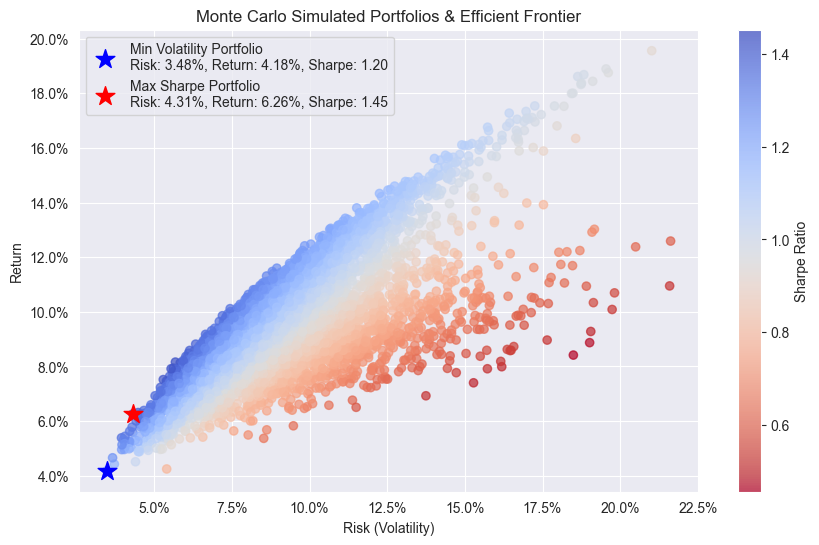

In [51]:
def plot_mvo_results(portfolios_df, min_vol_weights, max_sharpe_weights):

    # Extract key portfolio metrics
    volatilities = portfolios_df["Volatility"]
    returns = portfolios_df["Return"]
    sharpe_ratios = portfolios_df["Sharpe Ratio"]


    # Identify the optimal portfolios
    min_vol_index = portfolios_df["Volatility"].idxmin()  # Portfolio with minimum volatility
    max_sharpe_index = portfolios_df["Sharpe Ratio"].idxmax()  # Portfolio with highest Sharpe ratio

    min_vol_point = (volatilities[min_vol_index], returns[min_vol_index])  # (Risk, Return) of min-vol portfolio
    max_sharpe_point = (volatilities[max_sharpe_index], returns[max_sharpe_index])  # (Risk, Return) of max-Sharpe portfolio

    # Create a scatter plot for all simulated portfolios
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(volatilities, returns, c=sharpe_ratios, cmap="coolwarm_r", alpha=0.7)
    plt.colorbar(scatter, label="Sharpe Ratio")  # Add color bar to represent Sharpe ratios

    # Highlight the minimum volatility portfolio with a blue star
    plt.scatter(*min_vol_point, color='blue', marker='*', s=200,
                label=f"Min Volatility Portfolio\nRisk: {min_vol_point[0]:.2%}, Return: {min_vol_point[1]:.2%}, Sharpe: {sharpe_ratios[min_vol_index]:.2f}")

    # Highlight the maximum Sharpe ratio portfolio with a red star
    plt.scatter(*max_sharpe_point, color='red', marker='*', s=200,
                label=f"Max Sharpe Portfolio\nRisk: {max_sharpe_point[0]:.2%}, Return: {max_sharpe_point[1]:.2%}, Sharpe: {sharpe_ratios[max_sharpe_index]:.2f}")

    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    # Set axis labels and title
    plt.xlabel("Risk (Volatility)")
    plt.ylabel("Return")
    plt.title("Monte Carlo Simulated Portfolios & Efficient Frontier")

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()
# Plot
plot_mvo_results(portfolios, min_vol_weights, max_sharpe_weights)

#Q13
The minimum volatility portfolio heavily allocates to assets with lower variance and low correlation with other assets. For instance, non-equity instruments like FBNDX (bond fund) or SPGSCI (commodity index) often exhibit low volatility and minimal correlation with equities, making them prime candidates for a low-risk allocation.

Interestingly, some equity strategies with strong MA or BB filters (like AAPL-MAFlat or INTC-BB) also receive weight, likely because the technical strategy reduces return volatility.

The optimizer naturally shifts weights away from highly volatile or correlated instruments, and into those offering risk diversification — even if their standalone returns aren’t the highest.

This outcome reflects realistic portfolio construction, where the goal is not just minimizing individual asset risk, but overall portfolio volatility through strategic combination.

#Q14
The Maximum Sharpe Ratio Portfolio focuses on maximizing return per unit of risk. As expected, the optimizer allocates higher weights to strategies that offer high expected returns with moderate volatility and favorable correlation with the rest of the portfolio.

Strategies such as AAPL-MAFlat and EXC-BMK-MA received larger allocations due to their strong risk-adjusted returns. Some non-equity instruments (like FBNDX-MAShort or SPGSCI-MAFlat) might have lower standalone returns, but are retained in small portions for diversification benefit, which helps in reducing portfolio volatility.

The portfolio avoids overloading on any single asset and instead forms a balanced allocation that benefits from the uncorrelated nature of certain strategies. This balance ensures the portfolio achieves a Sharpe Ratio > 1.0, which is often considered excellent in practice.

In [52]:
def pretty_print_portfolio_weights(weights, asset_names, label="Portfolio"):
    df = pd.DataFrame({
        "Instrument": asset_names,
        "Weight": weights
    })

    # Filter for meaningful allocations (>1%)
    df = df[df["Weight"] > 0.01]

    # Sort by weight descending
    df = df.sort_values(by="Weight", ascending=False)

    # Format weight as percentage string
    df["Weight"] = df["Weight"].apply(lambda x: f"{x:.2%}")

    # Reset index for presentation
    df.reset_index(drop=True, inplace=True)

    print(f"\n {label} Weights:\n")
    print(df)
    return df

# Example usage
max_sharpe_df = pretty_print_portfolio_weights(max_sharpe_weights, myStrategies, label="Max Sharpe Portfolio")
min_vol_df = pretty_print_portfolio_weights(min_vol_weights, myStrategies, label="Min Volatility Portfolio")


 Max Sharpe Portfolio Weights:

      Instrument  Weight
0  FBNDX-MAShort  43.06%
1    GBP-MAShort  16.01%
2        INTC-BB  13.11%
3         PFE-BB  12.26%
4    AAPL-MAFlat   8.54%
5     EXC-BMK-MA   2.39%
6     GE-MAShort   2.36%
7  SPGSCI-MAFlat   2.27%

 Min Volatility Portfolio Weights:

      Instrument  Weight
0  FBNDX-MAShort  53.79%
1    GBP-MAShort  18.79%
2         PFE-BB  14.59%
3        INTC-BB   3.24%
4  SPGSCI-MAFlat   3.08%
5     EXC-BMK-MA   2.93%
6     GE-MAShort   2.87%


# Q15

## Yes, The Maximum sharpie is defenitely higher than in Q10, It was 1.27 in Q10, the maximum here is 1.45

In [53]:
filtered_master_df["Max_Sharpe_Portfolio"] = filtered_master_df.dot(max_sharpe_weights)


/var/folders/6_/v2lbn42d4jv_ftk2h_wj2fhr0000gn/T/ipykernel_85983/2735510304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_master_df["Max_Sharpe_Portfolio"] = filtered_master_df.dot(max_sharpe_weights)


# Q16

In [54]:
calculate_performance_stats(filtered_master_df).fillna(0)

,AAPL-MAFlat,EXC-BMK-MA,FBNDX-MAShort,GBP-MAShort,GE-MAShort,INTC-BB,PFE-BB,SPGSCI-MAFlat,Max_Sharpe_Portfolio
Average Annual Return,0.242433,0.086001,0.019116,0.054310,0.127579,0.085429,0.056666,0.078069,0.062623
Annual Risk,0.283875,0.261327,0.037919,0.094740,0.313761,0.127939,0.100509,0.174956,0.043098
Sharpe Ratio,0.854013,0.329092,0.504125,0.573256,0.406611,0.667734,0.563786,0.446222,1.453062
Max Drawdown,-0.705671,-1.008290,-0.116342,-0.198306,-0.837790,-0.290554,-0.147106,-0.730454,-0.072298
Success Ratio,0.671689,0.523750,0.641138,0.513915,0.518937,0.944758,0.942457,0.709144,0.542164


### Compared to the individual instruments the change in portfolio is immense, the average Annual risk was highest in AAPL with 0.24 but in the portfolio is is 0.062. In the same case the annual risk is very low in portfolio(0.04) compared to AAPL (0.28)

### When we compare it with FBNDX the risk increased a bit. i.e, 0.03 to 0.04 but the returns increased immensly from 0.019 to o.062

### When we look at the sharpe ration, it nearly got more than two times of the individual instruments.

### Yes, the maxDD has changed a lot in the total portfolio compared to individual instruments

# Q17

In [55]:
# Extract the daily returns of the maximum Sharpe ratio portfolio
max_sharpe_returns = filtered_master_df["Max_Sharpe_Portfolio"]

# Extract the daily returns of the S&P 500 (SPY-BMK-MA)
spy_returns = master_df["SPY-BMK-MA"]

# Compute the covariance between the maximum Sharpe ratio portfolio and S&P 500
covariance = np.cov(max_sharpe_returns, spy_returns)[0, 1]  # Take the off-diagonal element of the covariance matrix

# Compute the variance of the S&P 500 returns
variance_spy = np.var(spy_returns)  # Variance of S&P 500

# Calculate the Beta value
beta_max_sharpe = covariance / variance_spy

# Output the Beta value
beta_max_sharpe

np.float64(0.056650856444922605)

The calculated Beta value is 0.056, which is below 0.5. This implies the maximum Sharpe ratio portfolio has very low market risk and a weak correlation with the S&P 500. The portfolio has extremely low market risk, thus its returns are barely affected by changes in the S&P 500.

# Q18

## a

In [56]:
tickers = ["AAPL", "EXC", "GE", "INTC", "PFE", "FBNDX", "SPGSCI", "GBP"]
selected_columns = [f"{ticker}-BMK-MA" for ticker in tickers if f"{ticker}-BMK-MA" in master_df.columns]
benchmark_returns = master_df[selected_columns]

# Compute equal weights for each asset in the portfolio
num_assets = len(selected_columns)
weights = np.ones(num_assets) / num_assets  # Each asset gets an equal weight of 1/N

# Calculate the daily returns of the benchmark portfolio
benchmark_portfolio_returns = benchmark_returns.dot(weights)

# Compute the annualized Sharpe ratio
risk_free_rate = 0  # Assuming a risk-free rate of 0%
excess_returns = benchmark_portfolio_returns - risk_free_rate / 260  # Adjust for risk-free rate

# Calculate the Sharpe ratio
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(260)

# Output the Sharpe ratio of the benchmark portfolio
sharpe_ratio


np.float64(0.43549925295979236)

## b

In [57]:
tickers = ["AAPL", "EXC", "GE", "INTC", "PFE", "FBNDX", "SPGSCI", "GBP"]

selected_columns = [f"{ticker}-MAFlat" for ticker in tickers if f"{ticker}-MAFlat" in master_df.columns]
benchmark_returns = master_df[selected_columns]

# Compute equal weights for each asset in the portfolio
num_assets = len(selected_columns)
weights = np.ones(num_assets) / num_assets  # Each asset gets an equal weight of 1/N

# Calculate the daily returns of the benchmark portfolio
benchmark_portfolio_returns = benchmark_returns.dot(weights)

# Compute the annualized Sharpe ratio
risk_free_rate = 0  # Assuming a risk-free rate of 0%
excess_returns = benchmark_portfolio_returns - risk_free_rate / 260  # Adjust for risk-free rate

# Calculate the Sharpe ratio
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(260)

# Output the Sharpe ratio of the benchmark portfolio
sharpe_ratio


np.float64(0.6801657584745407)

## c

In [58]:
tickers = ["AAPL", "EXC", "GE", "INTC", "PFE", "FBNDX", "SPGSCI", "GBP"]
selected_columns = [f"{ticker}-MAShort" for ticker in tickers if f"{ticker}-MAShort" in master_df.columns]
benchmark_returns = master_df[selected_columns]

# Compute equal weights for each asset in the portfolio
num_assets = len(selected_columns)
weights = np.ones(num_assets) / num_assets  # Each asset gets an equal weight of 1/N

# Calculate the daily returns of the benchmark portfolio
benchmark_portfolio_returns = benchmark_returns.dot(weights)

# Compute the annualized Sharpe ratio
risk_free_rate = 0  # Assuming a risk-free rate of 0%
excess_returns = benchmark_portfolio_returns - risk_free_rate / 260  # Adjust for risk-free rate

# Calculate the Sharpe ratio
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(260)

# Output the Sharpe ratio of the benchmark portfolio
sharpe_ratio


np.float64(0.36017938530087623)

## d

In [59]:
tickers = ["AAPL", "EXC", "GE", "INTC", "PFE", "FBNDX", "SPGSCI", "GBP"]
selected_columns = [f"{ticker}-BB" for ticker in tickers if f"{ticker}-BB" in master_df.columns]
benchmark_returns = master_df[selected_columns]

# Compute equal weights for each asset in the portfolio
num_assets = len(selected_columns)
weights = np.ones(num_assets) / num_assets  # Each asset gets an equal weight of 1/N

# Calculate the daily returns of the benchmark portfolio
benchmark_portfolio_returns = benchmark_returns.dot(weights)

# Compute the annualized Sharpe ratio
risk_free_rate = 0  # Assuming a risk-free rate of 0%
excess_returns = benchmark_portfolio_returns - risk_free_rate / 260  # Adjust for risk-free rate

# Calculate the Sharpe ratio
sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(260)

# Output the Sharpe ratio of the benchmark portfolio
sharpe_ratio

np.float64(0.5252713780108806)

# no they do not outperform. All these Variations have far below sharpe ratio compared to the portfolio from Q14.

### Findings have been included in a power point presentation.